# Boat Signals, Damping and Filtering

## Preliminaries

This notebook investigates the "central" boat instruments and how they are combined and filtered/smoothed/damped to provide critical information, such as True Wind Direction and True Wind Speed.

First we will observe that many of the signals including apparent wind angle and speed (AWA and AWS), as well as boat speed (SPD) are quite "noisy".

## Glossary

- AWA: apparent wind angle, the angle of the wind blowing at the top the mast (fast but noisy)
- AWS: apparent wind speed, the speed at the mast head (fast and noisy)
- SPD: boat speed **through the water** measured with the paddle wheel speedo in the hull (fast and noisy)
- HDG: compass heading (on PG this is magnetic northa and not true north, though easily corrected using magnetic variation/declination).
- TWS: true wind speed, the speed of the wind over the ground (computed from the above quantities using the "wind triangle").
- TWD: true wind direction, the angle of the wind blowing over the ground (see "wind triangle").
- TWA: true wind angle, the angle of the wind over the ground reported relative the orientation of the boat (same)
- COG and SOG: course and speed over ground from the GPS (these are relative to true north not magnetic on PG).

In [1]:
# Load some libraries
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import process as p
import analysis as a
import chart as c
import global_variables as G
from utils import DictClass

from numba import jit

In [2]:
# Race data is stored in these files.
sail_logs = [
    DictClass(log='2019-11-16_10:09.pd', doc='Snowbird #1.', begin=41076, end=111668, twd=True),
    DictClass(log='2019-11-23_10:23.pd', doc='Practice.', twd=True),
    DictClass(log='2019-11-24_10:33.pd', doc='Practice.', twd=True),
    DictClass(log='2019-12-07_09:47.pd', doc='Snowbird #2.', begin=54316, end=109378, twd=True)
]

# Grab the first, "snowbird #1"
example = sail_logs[0]

print(f"Reading and analyzing {example.log}")
df = p.read_sail_log(example.log, discard_columns=True, skip_dock_only=False, trim=True, path=G.DATA_DIRECTORY, cutoff=0.3)


Reading and analyzing 2019-11-16_10:09.pd
Session from 2019-11-16 18:09:15.020000, 128865 rows, 3.5797222222222222 hours.


<IPython.core.display.Javascript object>


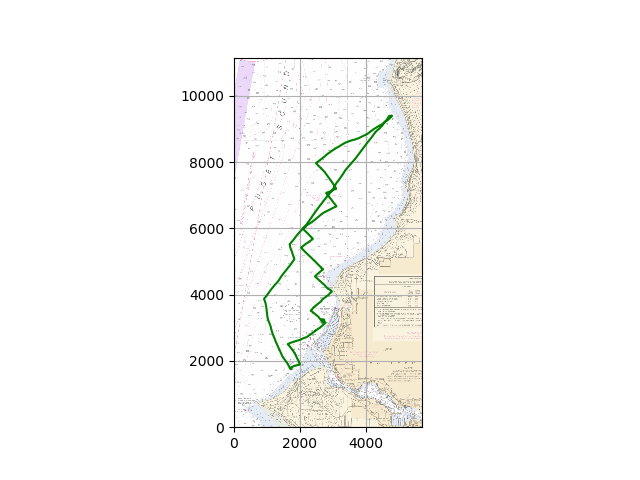

In [3]:
# Snowbird #1 was a day when we battled with Creative on the upwind leg from the last 
# mark to the finish
chart = c.plot_chart(df)
df = df.loc[example.begin : example.end]
c.draw_track(df, chart, color='green')

<IPython.core.display.Javascript object>


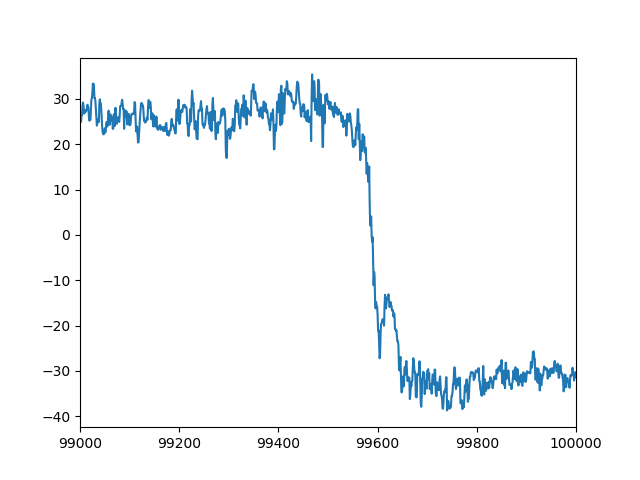

In [4]:
# Let's start by looking at just look at a bit of data, 100 seconds from the middle, centered on a tack.
seconds = 100
samples_per_second = 10
delay = seconds * samples_per_second
start = 99000

wide_slice = slice(start, start + delay)
wdf = df.loc[wide_slice]
plt.figure()
# RAWA is the raw values of AWA that are logged
wdf.rawa.plot()

# There are 10 samples per second, the ticks below are 200 samples, or 20 seconds.

<IPython.core.display.Javascript object>


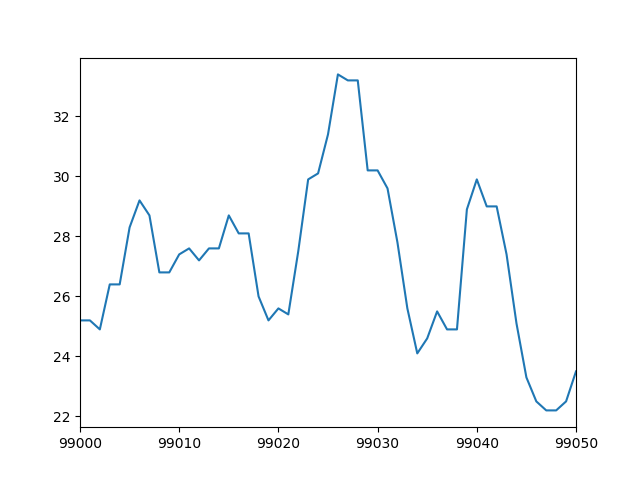

In [5]:
# Let's drill down and look at 5 seconds (50 samples)
narrow_slice = slice(start, start + 5 * 10)
ndf = df.loc[narrow_slice]
plt.figure()
ndf.rawa.plot()

## Noise, Signal, Damping, and Filtering

Noise is pure randomness, there is no structure and no clear physical explanation.

But in the above signal there is clear evidence of rapid oscillation.  Most likely this is **not** noise.  Remember that the wind sensor is at the top of the mast, 50 feet above the water, where small changes in boat heel can lead to large and rapid movement side to side.  As the boat cuts through rhythmic waves, it is plausible that regular oscilation in wind angle would result.

But is the useful information?  Probably not.  Neither the boat, nor the wind, is rotating 9 degrees in 0.5 seconds.  So these variations might as well be noise, and we are better of "filtering" them away.

The true AWA is hidden in this noise; if you were to display the raw wind sensor readings the numbers would be jumping around like crazy, almost impossible to read.  (On many boats you can adjust display settings to display the raw instrument readings directly.  Its not very useful.)

On our B&G boat, these issues are addressed by "damping", which is left a bit mysterious in the Triton and Zeus B&G documentation.  Damping is a number from 0 to 10, with higher numbers providing more smoothing and less noise, while also introducing significant delay.  Further information on signal processing is provided in the documentation for some of the more advanced B&G sail computers: H5000 and WTP3.  Most likely the onboard units are using exponential filtering, perhaps a non-linear version.

Note, that what is logged for AWA is not what is shown on the instrument display (Triton and Zeus), because the mast head sensor unit broadcasts raw AWA, while the displays present a filtered/damped version, which is not logged.

The logged values for true wind angle (TWA) are damped. On Peer Gynt, TWA (and TWS and TWD) are computed and broadcast by the autopilot computer (if the autopilot is off, then they missing from the logs).  These signals are damped **before** they are sent to other devices, including our logging device.

Since TWA is closely related to AWA, let's plot them both to get a sense of how damping works.

<IPython.core.display.Javascript object>


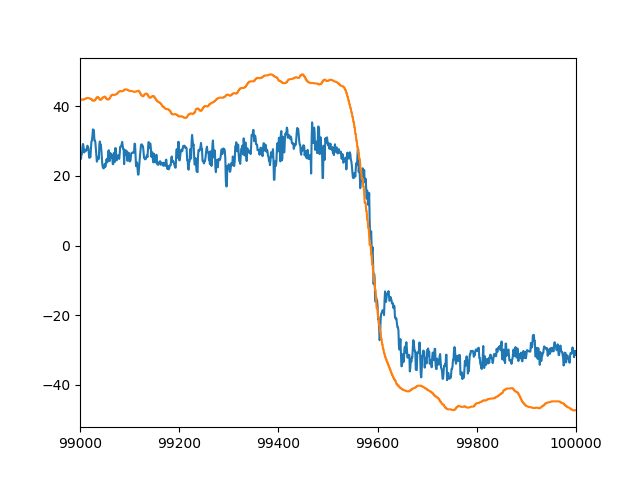

In [6]:
plt.figure()
# RAWA is the raw values of AWA that are logged
wdf.rawa.plot()
# And the "raw" TWA that is logged is quite different and much smoother.
wdf.rtwa.plot()

For more information on sailing instruments the book *Sail Smart: Understand Your Instruments to Sail Faster, Make the Right Calls & Win Races* by Mark Chisnell provides quite a bit of helpful info on boat instruments and measurements. [link](https://www.amazon.com/dp/B07F3CKRLH/ref=cm_sw_em_r_mt_dp_U_Px-gEbZJ52RTX).  The book is short, and for some it will repeat a lot of the basics, but it is helpful none the less.

Apparent wind conflates the "true wind" and the boat movement.  If the boat were stationary (e.g. at the dock) the apparent wind and the true wind are the same (both in speed and direction).  But if the boat is moving it induces apparent "wind" which is equal and opposite to the boat's speed and direction (when you stick your hand out the window of your car on the highway you observe the apparent wind).  **True Wind** is an attempt to subtract the boat's contribution.

Note, AWA, AWS, and SPD are directly measured by sensor units on the boat.  True wind must be computed.

True wind is more consistent and drives the strategy that you use on the race course.  Note TWA is reported relative to the boat, and TWD is reported relative to true north. We will see that they are otherwise the same.

We can compute the TWA from AWA/AWS/SPD using the code below.  It is basic vector addition (and trigonometry).

My preferred way to do this is to separate the two components of the apparent wind: i) the wind along the boat (which I think of as "boat north" pointing to the BOW) and ii) the wind perpedicular to the boat, "boat east" or PORT.  The SPD is then subtracted from boat north (since the boat is assumed to be moving forward in the "boat north" coordinates, though there may be [Leeway](https://en.wikipedia.org/wiki/Leeway)). All of this can be transformed into global north by adding the boats heading (which we will not do here).  Note, heading (HDG) is typically given in magnetic coordinates, not world, so be careful to add in the magnetic variation.

<IPython.core.display.Javascript object>


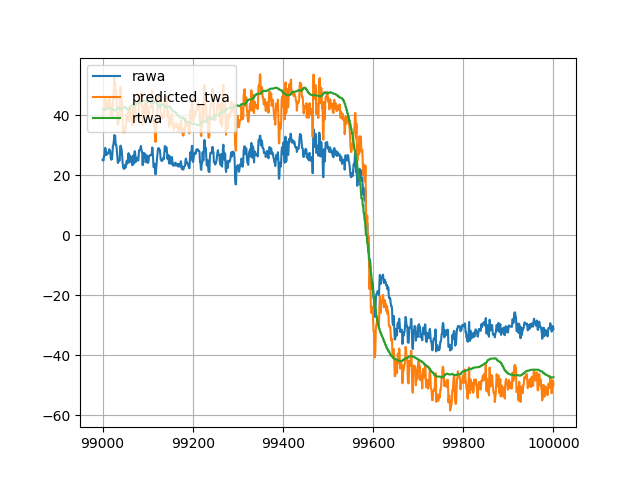

In [7]:
# Note, TWA is computed from AWA, AWS, and boat speed (SPD)
#
# This is "local" north, not global
tw_north = p.cos_d(df.rawa) * df.raws - df.rspd
tw_east = p.sin_d(df.rawa) * df.raws
df['predicted_twa'] = np.degrees(np.arctan2(tw_east, tw_north))
wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.predicted_twa, wdf.rtwa), "rawa predicted_twa rtwa".split())

There is general agreement between boat computed TWA and the "predicted TWA" using our formulas.  But there is a huge difference in noise.  The boat TWA is clearly filtered to remove noise.  

I am very impressed (or perhaps surprised) that the TWA computed on the boat seems to be **ahead** of the predicted TWA at the rise. Smoothing always introduced some delay. (More below... the TWA actually seems to move before AWA, which and seems to line up with heading.)

How is dampling/filtering/smoothing computed?

Is the smoothing done to AWA, AWS, and SPD before combination, or only after?

I started out by implementing a number of classical smoothing filters, my favorite being the [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter).  The Butterworth is a [causal](https://en.wikipedia.org/wiki/Causal_filter) optimal linear filter, which is parameterized by its ORDER and its CUTOFF frequency.  Order is related to complexity of the filter and its delay, and we'll just assume 5.  Cutoff is the frequency above which the filter rejects noise.  The Butterworth attempts to pass signal below CUTOFF and reject signal above CUTOFF.  

Unfortunately there is no CUTOFF that can both smooth out the local noise and track the large jumps.  Butterworth also introduces quite a bit of delay.

<IPython.core.display.Javascript object>


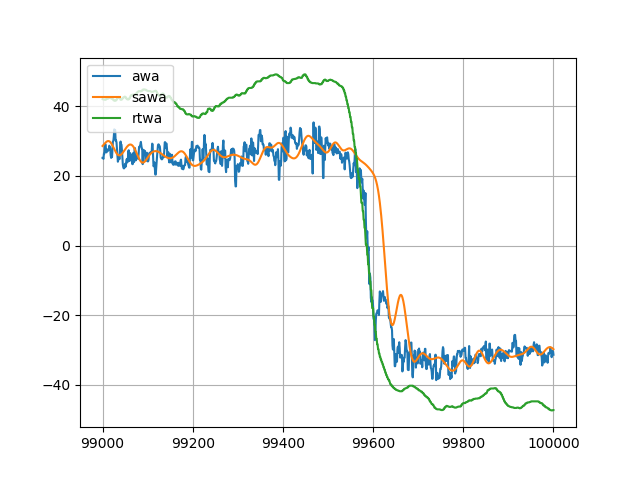

In [8]:
# Cutoff is 0.3 Hz. I.E. reject frequencies that rise or fall faster than about 1 second.
coeff = p.butterworth_filter(cutoff=0.3, order=5)

# Smooth angle applies the filter, with special handling of angles that wrap around at 360.
df['butter_causal_awa'] = p.smooth_angle(coeff, df.rawa, causal=True)
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rawa, wdf.butter_causal_awa, wdf.rtwa), "awa sawa rtwa".split())

Notice that the Butterworth signal is both more wiggly that TWA **and** very delayed (perhaps 4 seconds). By lowering the cutoff we can we can reduce the noise (remove wiggles) but that increases delay.  Conversely, larger cutoff reduces delay, but the noise grows as a result.

<IPython.core.display.Javascript object>


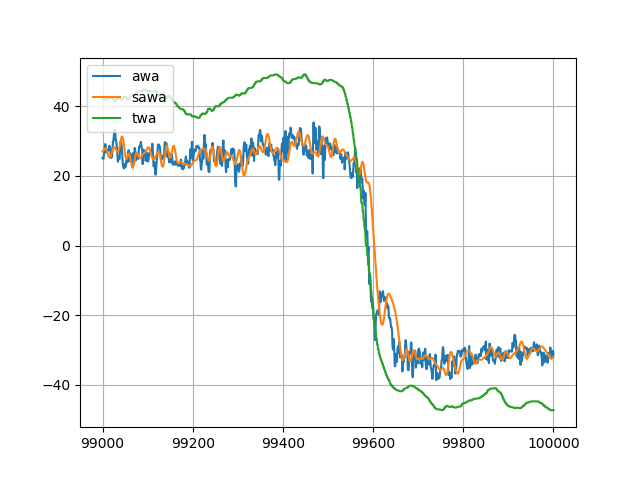

In [9]:
# Pass higher frequences.
coeff = p.butterworth_filter(cutoff=0.7, order=5)

df['butter_causal_awa'] = p.smooth_angle(coeff, df.rawa, causal=True)
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rawa, wdf.butter_causal_awa, wdf.rtwa), "awa sawa twa".split())

Above we see that delay is reduced, but noise increases past TWA.

To eliminate the delay there is a standard non-causal trick one can use, which is to first filter forward in time and then backward.  This **cannot** be used in real-time, since the entire signal must be available before processing (its fine for analysis done afterward).  My main motivation in this analysis is to understand what the boat does, and to create algorithms that might be used on the boat.

After digging through various writings on boat instrument processing I discovered an offhand comment regarding non-linear filtering.  The basic idea is to implement a non-linear version of a simple recursive filter 

$$ o_{t} = \alpha o_{t-1} + (1 - \alpha) i_t $$

where $o_t$ is the output and $i_t$ is the input (this is often called the *exponential filter*).  Larger values of $\alpha$ (up to 1.0) yield more smoothing.  

This sort of filter is very easy to implement, even on a tiny old computer,  but it is also primitive, providing poor filtering of noise.  If you want smoother filtering, then the signal is delayed (perhaps worse than a Butterworth).  Below is the basic recursive filter.  Note, the exponential filter is much like a Butterworth of order 1.

<IPython.core.display.Javascript object>


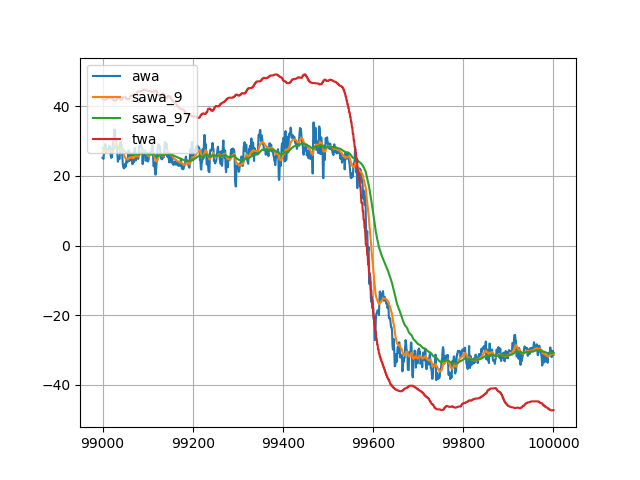

In [10]:
# Ignore the mysterious parameter of 10,000 for now.  Explained below.
df['sawa_9'], _ = p.exponential_filter_angle(np.array(df.rawa), 0.9, 10000)
alpha = 0.97
df['sawa_alpha'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, 10000)
wdf = df.loc[wide_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa_9, wdf.sawa_alpha, wdf.rtwa), "awa sawa_9 sawa_97 twa".split())


Above we see two runs of the exponential filter; higher alpha yields a smoother result.  TWA is included to show an "appropriate" amount of smoothing.

The large value of alpha is pretty good for filtering, but it introduces a **large** delay!  The smaller value tracks more closely (with shorter delay), but it is too wiggly and still delayed.

Like the Butterworth, the exponential filter is linear.  The non-linear version introduces a tracking error threshold.  
- If the difference between the filtered output and the raw input is larger than threshold then dynamically reduce the value of alpha.  
- If the tracking error is less than threshold than dynamically increase the threshold (gradually back to original).

There are a couple of magic numbers here, like how much to decrease or increase the value of alpha (which are hard to set).  Code is below.  Note, I could not figure out a good way to do this with Numpy magic (which makes things fast in Python).  The result is a very slow Python loop.  I sped this up with the [Numba](http://numba.pydata.org/) package for compiling Python functions (see the `jit` decorator).

The code for filtering angles is a bit more complex (angles wrap around at 360).  Below is the simpler (non-angle) version.

Why is this a good filter?  All filters are trying to separate the noise from the underlying signal. It is plausible that the underlying signal is mostly changing slowly (between tacks and gybes), with additional large steps (at tacks/gybes).  TWA must look a bit like a classic square wave.  

Imagine a filter which had advanced knowledge of the tacks.  This filter could use two values of alpha, say 0.99 between the tacks and 0.5 during the tacks.  The non-linear exponential filter moves between these values of alpha by looking at the output of the filter.  If the tracking is poor, then the signal must be in the step regime, so alpha is reduced.  If tracking is good then alpha is increased.

The Butterworth is stuck processing both regimes using the same parameters.

AWA and TWA look a lot like a square wave.  Tacks and gybes introduce big changes, but otherwise you sail on a consistent wind angle.  Tacks and gybes also introduce changes in AWS and SPD as well, though less dramatically.

(Note, I suppose this sort of processing could be justified by a two state hidden markov model (HMM) which could work along similar lines.)

In [11]:
@jit(nopython=True)
def exponential_filter(sig, alpha, max_error):
    """
    Apply a non-linear exponential filter, where alpha is the decay (higher alpha is longer decay and higher smoothing).  If the error is
    greater than max_error, then alpha is repeatedly reduced  (faster decay).
    """
    beta = beta0 = 1 - alpha
    res = np.zeros(sig.shape)
    betas = np.zeros(sig.shape)
    res[0] = sig[0]
    betas[0] = beta
    for i in range(1, len(sig)):
        res[i] = (1 - beta) * res[i-1] + beta * sig[i]
        if np.abs(res[i] - sig[i]) > max_error:
            beta = min(1.5 * beta, 0.5)
        else:
            beta = (beta + beta0) / 2
        betas[i] = beta
    return res, betas

<IPython.core.display.Javascript object>


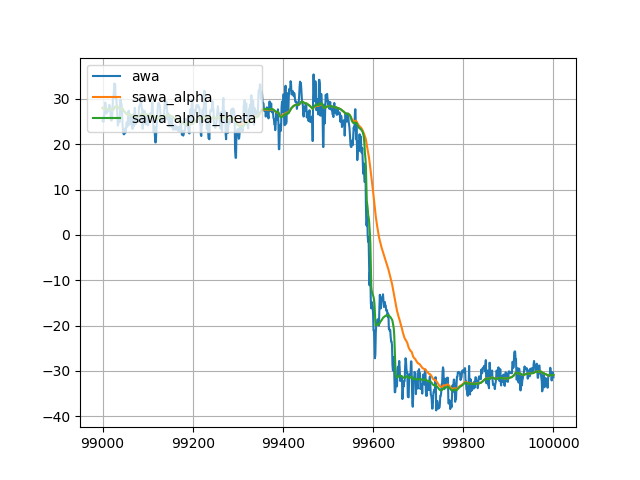

<IPython.core.display.Javascript object>


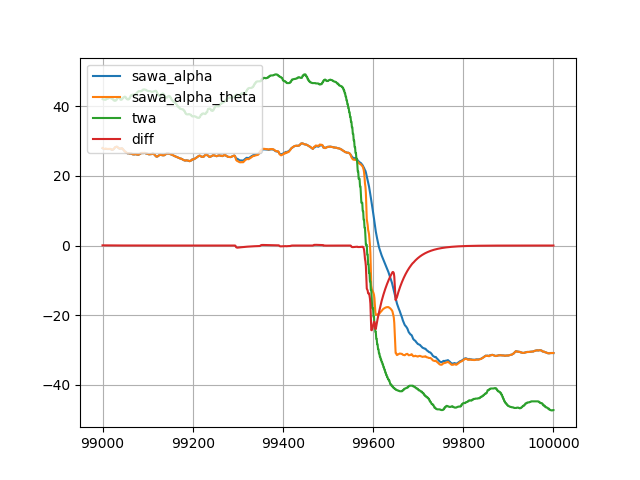

In [13]:
# In order to better understand this filter, we will focus on AWA (and not the more complex TWA).

# Above we used 10,000 for max_error, which essentially reduced the filter to simple exponential filter.
# We'll pick more reasonable values here.
max_error = 6  # the threshold, which should be roughly the magnitude of the noise 
alpha = 0.97
df['sawa_97'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, 10000)
df['sawa_alpha_theta'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, max_error)

wdf = df.loc[wide_slice]
diff = wdf.sawa_alpha_theta - wdf.sawa_alpha

# This new filtered signal closely tracks AWA, while reject most of the noise.
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa_alpha, wdf.sawa_alpha_theta), 
                        "awa sawa_alpha sawa_alpha_theta".split())


# Second plot is a bit cleaner because it leaves out the RAWA
c.quick_plot(wdf.index, (wdf.sawa_alpha, wdf.sawa_alpha_theta, wdf.rtwa, diff), 
                        "sawa_alpha sawa_alpha_theta twa diff".split())

In the above figure DIFF shows the difference between the linear and non-linear exponential filter. Where the difference is ZERO the max error threshold is not doing much.  We can see that MAX_ERROR only plays a role in the regions of the tack (where a rapid change in AWA is triggered).  In regions on consistent sailing, there is no difference between the two signals.

**How is theta determined?** In this case by eye.  After selecting a threshold, like 6, you can examine the tracking error to see if the signal strays far from the raw.

<IPython.core.display.Javascript object>


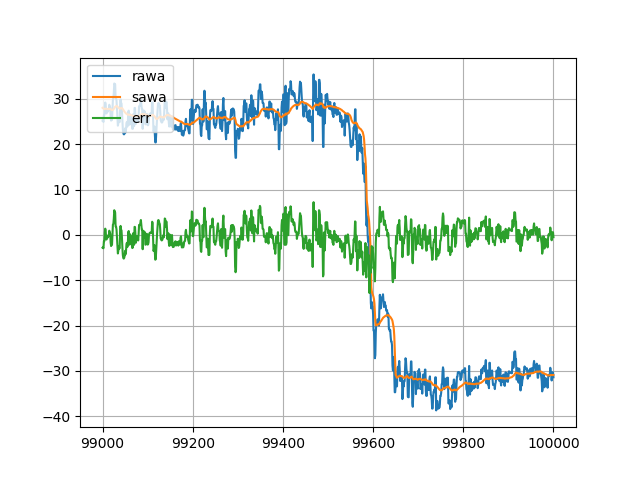

In [14]:
# Now the last parameter can be defined, it is the max error.  This is max_tracking_error threshold.
theta = 6  # the threshold, which should be approximate the noise 
alpha = 0.97
df['sawa_alpha_theta'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, theta)

wdf = df.loc[wide_slice]

err = wdf.rawa - wdf.sawa_alpha_theta
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa_alpha_theta, err), 
                        "rawa sawa err".split())

We can see that the ERR signal looks a lot like random noise (or perhaps it is the noise introduced by the motion of the mast).  And the noise has a peak to peak magnitude of about of about 6.

<IPython.core.display.Javascript object>


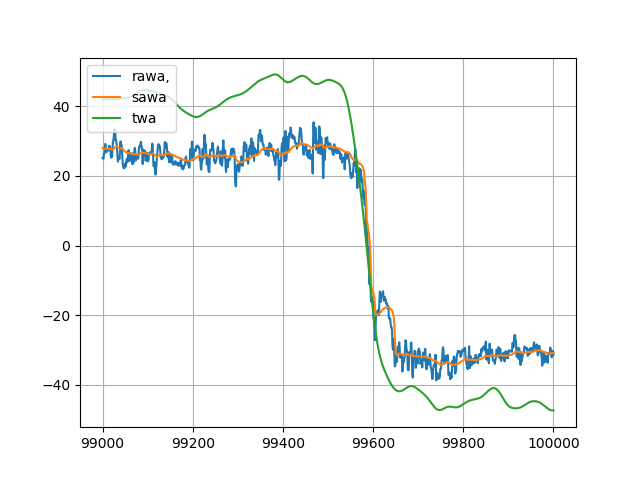

<IPython.core.display.Javascript object>


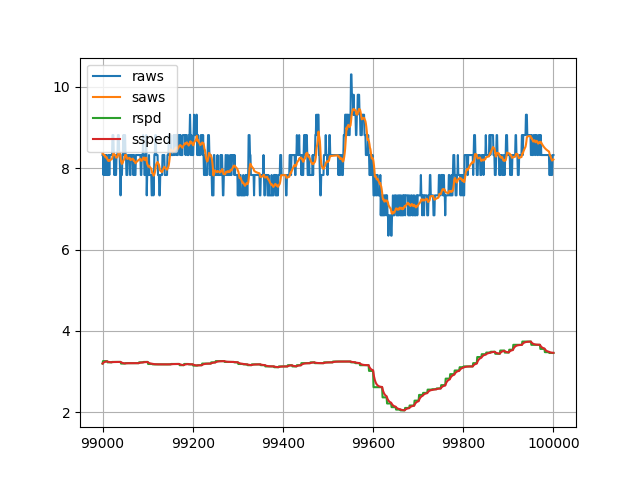

In [15]:
# Note different signals require different settings of alpha, because they have different 
# dynamics and noise.
theta = 6  
alpha = 0.97
df['sawa'], _ = p.exponential_filter_angle(np.array(df.rawa), alpha, theta)

# Less noise and smaller theta values.
df['saws'], _ = p.exponential_filter(np.array(df.raws), 0.93, 0.5)
df['sspd'], _ = p.exponential_filter(np.array(df.rspd), 0.8, 0.5)

wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa, wdf.twa), "rawa, sawa twa".split())
c.quick_plot(wdf.index, (wdf.raws, wdf.saws, wdf.rspd, wdf.sspd), "raws saws rspd ssped".split())

Let's return to the calculation of TWA/TWS from raw instrument readings.

We have three options for computing a smoother version:

1. Smooth the TWA after calculation from raw signals.
1. Compute TWA from the smoothed signals.
1. Do both.

In [16]:
# First compute the baseline TWA
tw_north = p.cos_d(df.rawa) * df.raws - df.rspd
tw_east = p.sin_d(df.rawa) * df.raws
df['predicted_twa'] = np.degrees(np.arctan2(tw_east, tw_north))

# And then TWA from smoothed signals
tw_north = p.cos_d(df.sawa) * df.saws - df.sspd
tw_east = p.sin_d(df.sawa) * df.saws
df['predicted_stwa'] = np.degrees(np.arctan2(tw_east, tw_north))

# And then the smoothed TWA from the baseline
df['spredicted_twa'], _  = p.exponential_filter_angle(np.array(df.predicted_twa), alpha, theta)

# And then both
df['spredicted_stwa'], _  = p.exponential_filter_angle(np.array(df.predicted_stwa), alpha, theta)

<IPython.core.display.Javascript object>


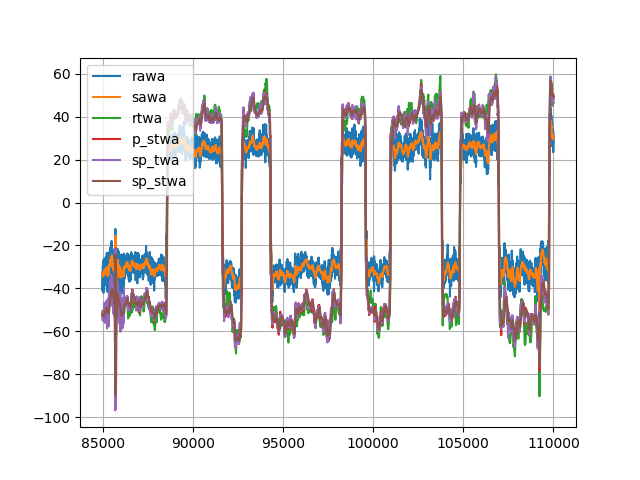

<IPython.core.display.Javascript object>


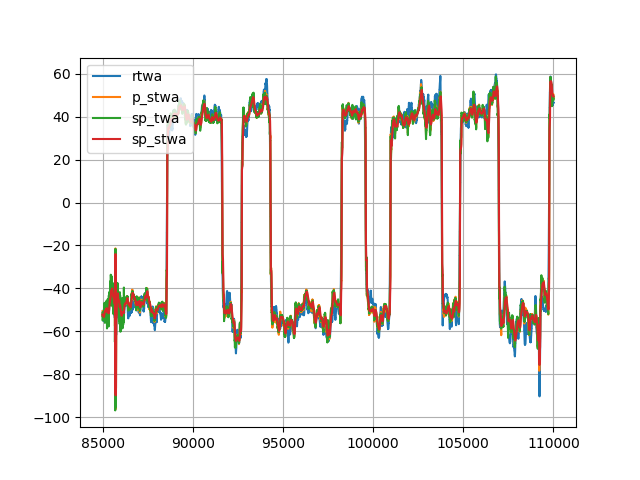

In [17]:
# Narrow focus to a set of tacks... keeps things simple
tacks_slice = slice(85000, 110000)
wdf = df.loc[tacks_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.sawa, wdf.rtwa, wdf.predicted_stwa, wdf.spredicted_twa, wdf.spredicted_stwa),   
            "rawa sawa rtwa p_stwa sp_twa sp_stwa".split())
c.quick_plot(wdf.index, (wdf.rtwa, wdf.predicted_stwa, wdf.spredicted_twa, wdf.spredicted_stwa),   
            "rtwa p_stwa sp_twa sp_stwa".split())


<IPython.core.display.Javascript object>


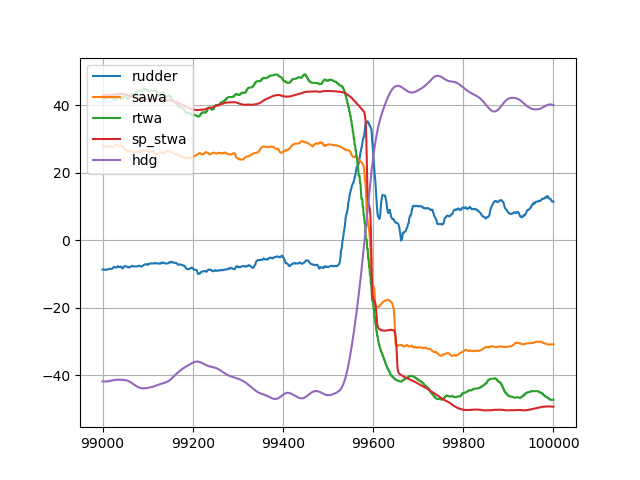

In [19]:
# Let's drill down into one tack.
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rudder, wdf.sawa, wdf.rtwa, wdf.spredicted_stwa, wdf.hdg-175),   
            "rudder sawa rtwa sp_stwa hdg".split())

# Note that TWA seems to be **leading** AWA!
# Note how TWA (from the boat) and HDG have very similar shapes (inverted)!

The figure above is very interesting.

We've added RUDDER and HDG to help identify the beginning of the tack (in a sense the tack cannot begin **before** the rudder is turned).  As we expect, after the rudder is turned the HDG responds almost immediately (less than a second). 

But AWA seems to lag the change in HDG by 2+ seconds (this is true for raw and smoothed AWA).  In a simple model this makes no sense.  Forget, for a moment, that this is a sailboat.  Instead imagine this is a wind sensor on a moving platform.  If you were to rotate the wind sensor toward the wind, then the AWA should decrease (so should the TWA).  

But I do not believe this is an artifact.

**MY conjecture is that a change in HEEL introduces apparent wind on the mast head.**  As the boat rolls from starboard heel to port heel, the mast head **moves to windward**.  Motion to windward should increase the AWA.

We can investigate this by first smoothing heel (though this time with a non-causal Butterworth for now), and then differentiating (to get roll rate). Finally we can multiply by the mast height to get the velocity at the mast head.

Note, this boat does **not** have a high quality, high frequency HEEL sensor.  Currently the external GPS has both a compass, and a roll/pitch sensor.  Roll is heel,  but it is only reported once a second (which may not be sufficient for this analysis).

<IPython.core.display.Javascript object>


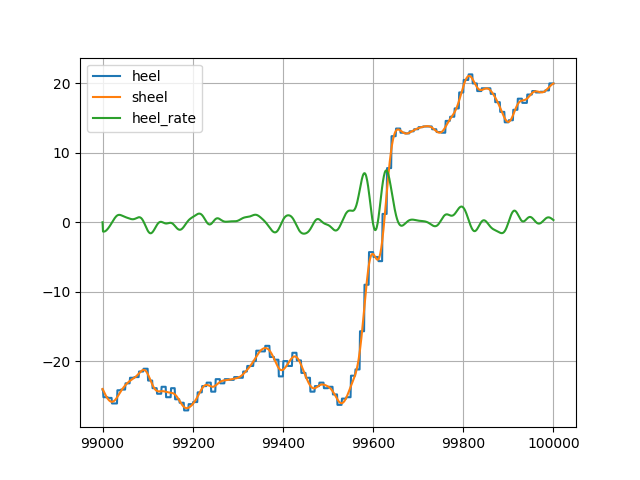

In [22]:
# Compute a smoothed version of heel.  Note the cutoff is set to 0.3 Hz.  Since the signal is sampled at 1 Hz 
# Nyquist says we cannot hope measure any signal higher than 0.5 Hz.
coeff = p.butterworth_filter(cutoff=0.3, order=5)
# Note causal is false, which will filter the signal but not introduce any delay.
sheel = p.smooth_angle(coeff, wdf.zg100_roll, causal=False)

# Why the Butterworth?  It is not straightforward to apply the exponential filter defined above.  
# The signal is reported at 10Hz, but it is measured at 1Hz.  This introduce at artifact that the signal 
# appears to be constructed from step edges.
sheel2, _ = p.exponential_filter_angle(np.array(wdf.zg100_roll), 0.9, 10000)

# Compute the degrees per second rate of change of heel
sample_rate = 10
heel_rate = sample_rate * np.diff(sheel, prepend=sheel[0])

# Convert to masthead velocity
feet_per_meters = 0.3048
mast_height = 50 * feet_per_meters
mast_vel = mast_height * np.radians(heel_rate)

c.quick_plot(wdf.index, (wdf.zg100_roll, sheel, heel_rate), 
            "heel sheel heel_rate".split())

Interestingly we can clearly see a double peak in the roll rate centered arount the tack.  While this does not happen in every case it is not uncommon.  In a slow tack, as the boat passes head to wind there is a period where the heel is constant.

<IPython.core.display.Javascript object>


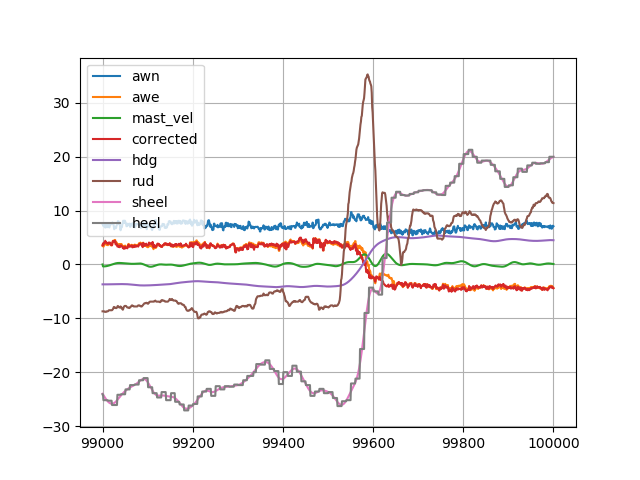

<IPython.core.display.Javascript object>


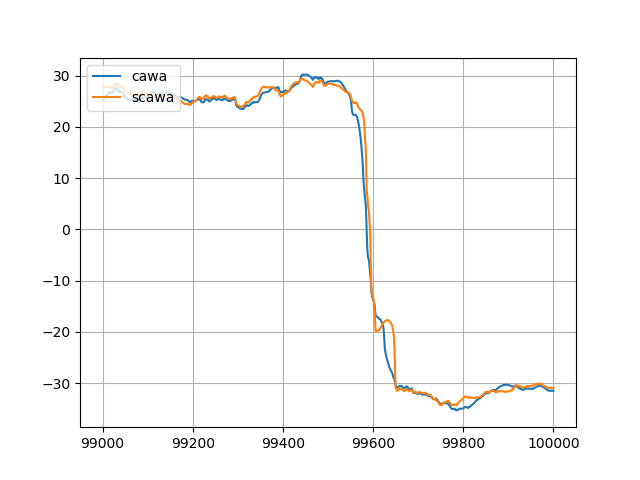

In [25]:
# Break apparent wind into the component aligned with the boat "north" and the component aligned with roll, "east".
aw_n = wdf.raws * np.cos(np.radians(wdf.rawa))
aw_e = wdf.raws * np.sin(np.radians(wdf.rawa))

correction = mast_vel

# Corrected 
caw_e = aw_e - correction

c.quick_plot(wdf.index, (aw_n, aw_e, mast_vel, caw_e, 0.1*(wdf.hdg-170), wdf.rudder, sheel, wdf.zg100_roll), 
            "awn awe mast_vel corrected hdg rud sheel heel".split())

cawa = np.degrees(np.arctan2(caw_e, aw_n))
caws = np.sqrt(np.square(aw_n) + np.square(caw_e))

scawa, _ = p.exponential_filter_angle(np.array(cawa), alpha, theta)
c.quick_plot(wdf.index, (scawa, wdf.sawa),
                        "cawa scawa sawa".split())


The corrected AWA now **leads** smoothed AWA by over a second, and there is no weird bump at the end.

<IPython.core.display.Javascript object>


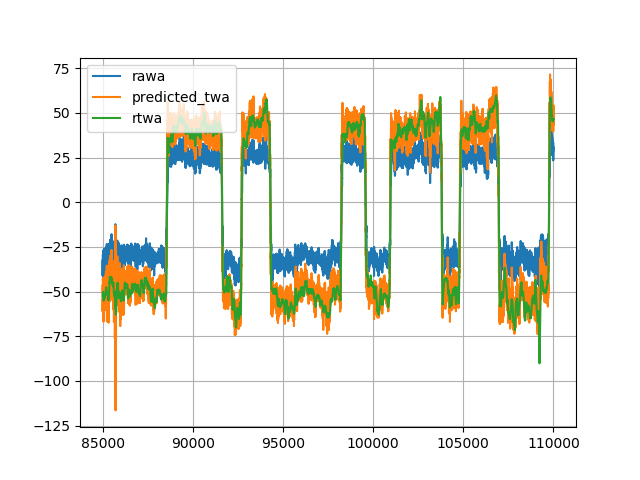

/Users/viola/GDriveBV/Sailboat/Code/Python/sailing/chart.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(num=fignum)


<IPython.core.display.Javascript object>


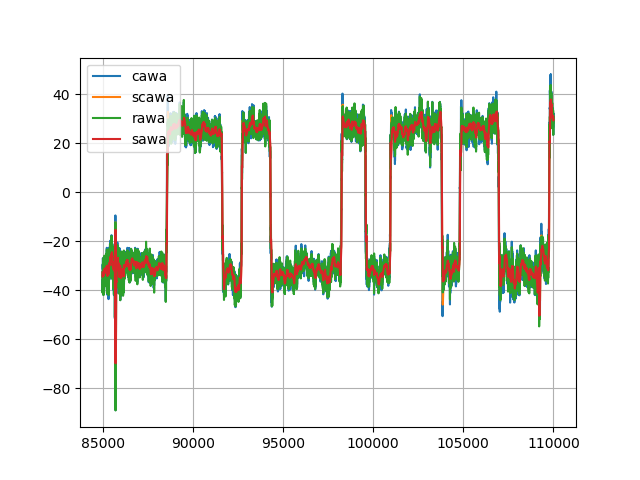

In [26]:
# Repeat for the entire signal


# Compute a smooth version of heel.  Note the cutoff is set to 0.3 Hz.  Since the signal is sampled at 1 Hz 
# Nyquist says we cannot hope measure any signal higher than 0.5 Hz.
coeff = p.butterworth_filter(cutoff=0.3, order=5)
# Note causal is false, which will filter the signal but not introduce any delay.
sheel = p.smooth_angle(coeff, df.zg100_roll, causal=False)

# Compute the degrees per second rate of change of heel
sample_rate = 10
heel_rate = sample_rate * np.diff(sheel, prepend=sheel[0])

# Convert to masthead velocity
mast_vel = mast_height * np.radians(heel_rate)

# Break apparent wind into the component aligned with the boat "north" and the component aligned with roll, "east".
aw_n = df.raws * np.cos(np.radians(df.rawa))
aw_e = df.raws * np.sin(np.radians(df.rawa))

# Corrected 
caw_e = aw_e - mast_vel

df['cawa'] = np.degrees(np.arctan2(caw_e, aw_n))
df['caws'] = np.sqrt(np.square(aw_n) + np.square(caw_e))

df['scawa'], _ = p.exponential_filter_angle(np.array(df.cawa), alpha, theta)
df['scaws'], _ = p.exponential_filter(np.array(df.caws), 0.93, 0.5)

tw_north = p.cos_d(df.cawa) * df.caws - df.rspd
tw_east = p.sin_d(df.cawa) * df.caws

df['predicted_twa'] = np.degrees(np.arctan2(tw_east, tw_north))
# increase smoothness... seems to be a better fit
alpha = 0.97
df['spredicted_twa'], _  = p.exponential_filter_angle(np.array(df.predicted_twa), alpha, theta)

wdf = df.loc[tacks_slice]
c.quick_plot(wdf.index, (wdf.rawa, wdf.predicted_twa, wdf.rtwa), "rawa predicted_twa rtwa".split())

c.quick_plot(wdf.index, (wdf.cawa, wdf.scawa, wdf.rawa, wdf.sawa),
                        "cawa scawa rawa sawa".split())


<IPython.core.display.Javascript object>


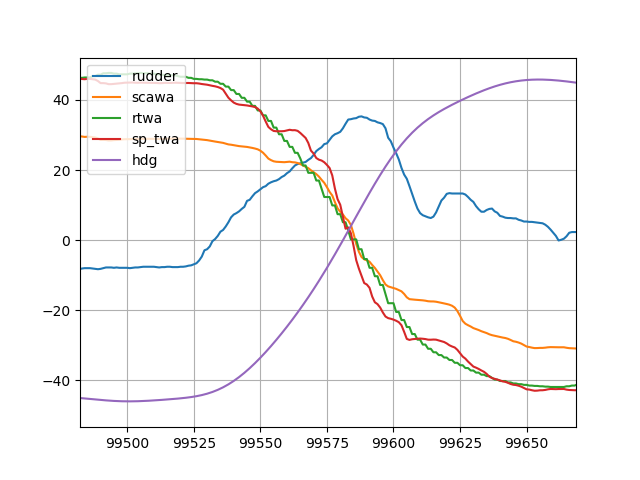

In [28]:
wdf = df.loc[wide_slice]

c.quick_plot(wdf.index, (wdf.rudder, wdf.scawa, wdf.rtwa, wdf.spredicted_twa, wdf.hdg-175),   
            "rudder scawa rtwa sp_twa hdg".split())

## Summary 

1. We have defined a non-linear exponential filter that appears to remove noise without introducing too much delay.

Conventional causal linear filtering introduced too much delay.

2. We created a scheme for correcting AWA using heel (aka roll).  

We observed a delay in the **raw AWA** from what we expected to see (it should track HDG closely). Correcting with the derivative of the heel reduces this delay significantly.

(For the time being let's ignore these observations and return to the estimate of TWA/TWD/TWS.  In particular I do not beleive the B&G instruments on my boat are using HEEL to correct AWA, so we will return to this later.)


## Back to TWA/TWS

While we can clearly see that the fit is much better than before there are still some issues.

1. The fit to TWA is good on the coarse level, but does not fit in the details.
1. TWA is both smoother and it **leads** our predicted TWA.

(Both of these issues are subtle.)

Another observation is worth making. **Notice that TWA and HDG are mirror images**.  Though it might be hard to see in this graph.  We can investigate this be trying to predict TWA from HDG alone.  

In [29]:
def least_square_fit(target, signal):
    "Compute the least squares fit of target from signal."
    a = np.vstack((signal, np.ones((len(signal))))).T
    b = np.asarray(target)
    fit = np.linalg.lstsq(a, b, rcond=None)[0]
    predictions = a.dot(fit)
    return fit, predictions

<IPython.core.display.Javascript object>


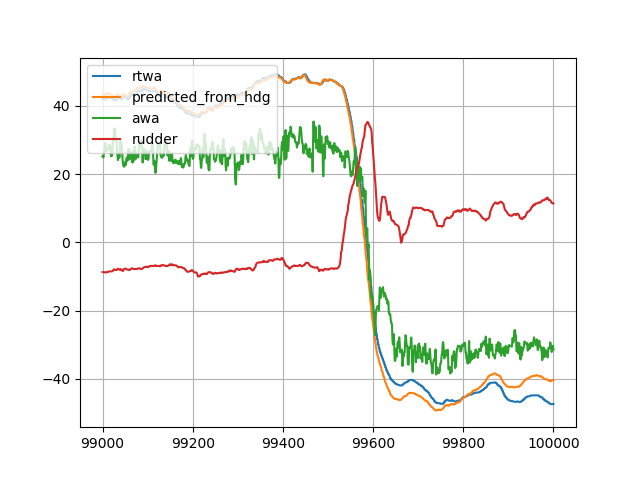

In [31]:
# Let's try to predict the TWA from HDG alone ?!?!!?
wdf = df.loc[wide_slice]
# For a short time slice is TWA a linear function of HDG?
fit, pred = least_square_fit(wdf.rtwa, wdf.rhdg)
c.quick_plot(wdf.index, (wdf.rtwa, pred, wdf.rawa, wdf.rudder), "rtwa predicted_from_hdg awa rudder".split())

In [32]:
print(f"Best fit for TWA is {fit[1]:.3f} {fit[0]:+.3f} * HDG")
abs_error = np.abs(wdf.rtwa - pred)
print(f"Average error is {np.mean(abs_error):.3f} degrees")


Best fit for TWA is 179.367 -1.021 * HDG
Average error is 1.817 degrees


To repeat, **we can predict TWA from HDG alone**!!  With an average error of about 1.8 degrees.

Both the fit and the graph show that the HDG and TWA are closely related (the blue and orange curves above).

Why is it possible to predict TWA from HDG alone?  It actually makes sense from a physical standpoint: if **TWA = (TWD - HDG)** and **TWD** is roughly constant over a period of time (1000/10 = 100 seconds). During this period TWD must have been approximately 179 degrees.  

To review, the rudder is turned at $t = 99500$ and the HDG (and TWA) respond very soon after (less than a second).  The AWA is still above 20 until 99572 (5 seconds!), but at this point TWA has dropped from 45 down to 14 degrees!!

What is going on here?  Why does the change in TWA come ahead of the change in AWA?  Why does it seem to track HDG almost perfectly?

Perhaps the above framework for computing TWA/TWS and filtering are too simplistic.

Rather than estimate TWA/TWS, perhaps it is better to estimate TWD/TWS (true wind direction and speed).  This is a quantity of the **world**, and while it varies with time, these processes do not depend on the boat.  So for example, some boats tack a lot and others very rarely.  Some boat have great drivers that keep a consistant TWA and others vary a lot.  Estimating TWA requires a filtering process that can be robust to these differences.  TWD depends only on the physics of wind in the world.

TWA is then computed from TWD by subtracting HDG. And this explains why TWA can lead AWA. If we can estimate TWD, the TWA will react immeadiately as HDG changes. 

In [33]:
# Too many open graphs... 
plt.close('all')

The average absolute difference between TWD and TWA+HDG is 0.27130532791488554
The 99th percentile of the abs difference is 2.609765180445927
The max abs difference is 6.447948450491822


<IPython.core.display.Javascript object>


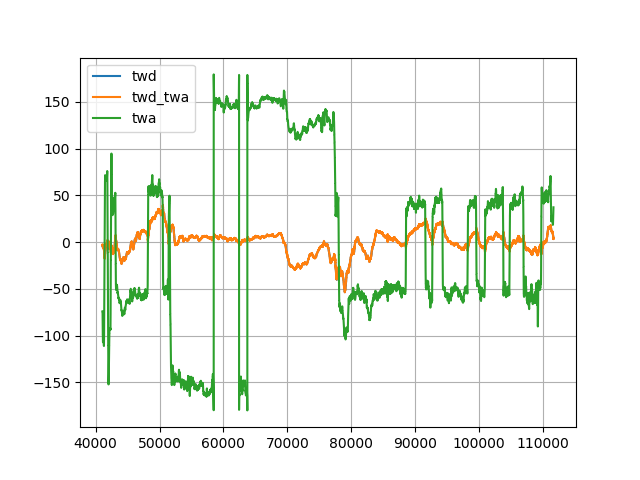

In [35]:
# Let's verify that TWD and TWA are directly related by HDG + variation
variation = df.variation.mean()
twd_from_twa = np.mod(df.rtwa + df.hdg + variation, 360)

abs_diff = np.abs(df.rtwd - twd_from_twa)

print(f"The average absolute difference between TWD and TWA+HDG is {abs_diff.mean()}")
print(f"The 99th percentile of the abs difference is {np.percentile(abs_diff, 99)}")
print(f"The max abs difference is {np.percentile(abs_diff, 100)}")

m = df.rtwd.mean()
c.quick_plot(df.index, (df.rtwd-m, twd_from_twa-m, df.rtwa),
               "twd twd_twa twa".split())


### How to estimate TWD/TWS directly?

I started out considering a Kalman filter.  The classic Kalman filter would proceed by iterating two steps: propagate and update.

A Kalman filter works in reverse from our approach above: given the current estimate of TWD/TWS (and HDG and SPD) it predicts AWA, AWS (rather than computing TWD/TWS from AWA/AWS).  If these predictions are in error a Kalman filter updates TWD/TWS to reduce these errors.  This is the "update step".

Propagate takes the current estimate and computes a new estimate.  This is the place to incorporate our sense of how fast wind direction may change.

A fully probabilistic derivation of the Kalman filter also involves covariance matrices.

A simpler, though similar alternative, is an iterative filter, which starts with a guess at TWD/TWS (perhaps random).  For each new observation perform the following stesp.

1. Observe AWA, AWS, HDG, and SPD
1. Predict AWA and AWS from HDG, SPD and the current guess for TWD and TWS
1. Measure the error in this prediction.
1. Update TWD/TWS to reduce this error. 

By keeping the changes in the final step small the filter produces a smooth version of TWD/TWS.   

### Update equations

The goal is to determine how to update estimates for TWA and TWS given observations.  We will do this by taking the derivative of the observation equations.  These derivatives are used to update the estimates to reduce the residuals.

Short hand:

    twa = twd - (hdg + var)
    c   = cos(twa)
    s   = sin(twa)

These are the predicted observations, given the hidden state: TWD/TWS.

    predicted_aw_n = spd + c * tws
    predicted_aw_e =       s * tws

And these are the residuals (the difference between actual and predicted).

    r_n = (aw_n - predicted_aw_n)
    r_e = (aw_e - predicted_aw_e)
    
And below are the derivates of aw_n and aw_e with respect to tws and twd (in that order).
    
    d_aw_n = [    c,   tws * -s]
    d_aw_e = [    s,   tws *  c]
    
Given residuals, we can update the parameters using the derivatives of the predictions

    delta_tws = r_n * c         + r_e * s
    delta_twa = r_n * tws * -s  + r_e * tws * c

Sure...  that is the math,  but what is the intuition?  Take one half of one term:

    delta_tws = r_n * c
              = (aw_n - predicted_aw_n) * cos(twa)
    
It says that if aw_n is greater than the predicted, then increase tws if twa is less than 90, and decrease if it greater than 90.

    delta_twa = r_n * tws * -s
              = (aw_n - predicted_aw_n) * tws * -1 * sin(twa)
              
This says that if aw_n is greater than predicted, then decrease twa.

**Note**, these are directions of update tws and twd over time.  The rate of change is proportional to an adaptation rate $\epsilon$.  Small values for $\epsilon$ will lead to small and gradual changes in twd/tws: smoother estimates but larger residuals.  Small values introduce smoothing/damping/filtering. 


In [36]:
@jit(nopython=True)
def estimate_true_wind_helper(epsilon, aws, awa, hdg, spd, tws, twd, variation, tws_mult):
    twd = np.radians(twd) + np.zeros(awa.shape)
    tws = tws + np.zeros(awa.shape)
    res_n = np.zeros(awa.shape)
    res_e = np.zeros(awa.shape)
    aw_n = aws * np.cos(np.radians(awa))
    aw_e = aws * np.sin(np.radians(awa))

    rhdg = np.radians(hdg)
    variation = np.radians(variation)

    for i in range(1, len(aws)):
        twa = twd[i-1] - (rhdg[i] + variation)
        c = np.cos(twa)
        s = np.sin(twa)
        # The forward predictions
        f_aw_n = spd[i] + c * tws[i-1]
        f_aw_e =          s * tws[i-1]

        # Residuals
        res_n[i] = (aw_n[i] - f_aw_n)
        res_e[i] = (aw_e[i] - f_aw_e)

        # derivatives
        delta_tws = res_n[i] * c + res_e[i] * s
        delta_twd = res_n[i] * tws[i-1] * -s + res_e[i] * tws[i-1] * c

        # Hack, which the update to TWS and TWD don't have the same magnitude
        tws[i] = epsilon * tws_mult * delta_tws + tws[i-1]
        twd[i] = epsilon * delta_twd + twd[i-1]

    return np.degrees(twd), tws, res_n, res_e

def estimate_true_wind(epsilon, df, awa_mult=1.0, aws_mult=1.0, spd_mult=1.0, awa_offset=0, tws_mult=30):
    return estimate_true_wind_helper(epsilon,
                                     aws = aws_mult * np.asarray(df.raws),
                                     awa = awa_mult * np.asarray(df.rawa) + awa_offset,
                                     hdg = np.asarray(df.rhdg),
                                     spd = spd_mult * np.asarray(df.rspd),
                                     tws = df.tws.iloc[0],
                                     twd = df.twd.iloc[0],
                                     variation = df.variation.mean(),
                                     tws_mult = tws_mult
                                    )

0.9729098356024904
0.6164349000275867
1.6011210814296135


<IPython.core.display.Javascript object>


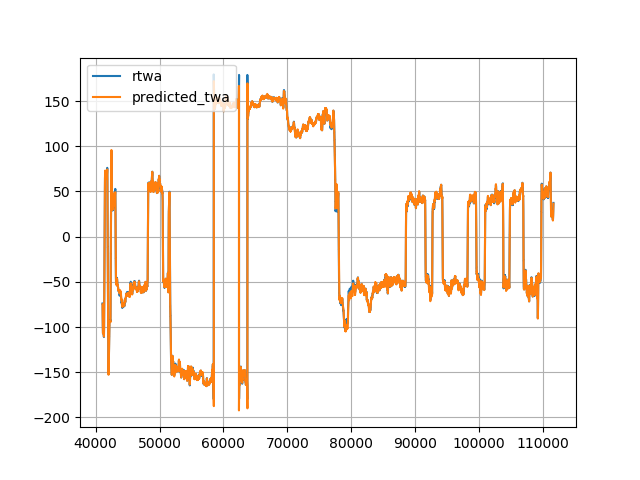

<IPython.core.display.Javascript object>


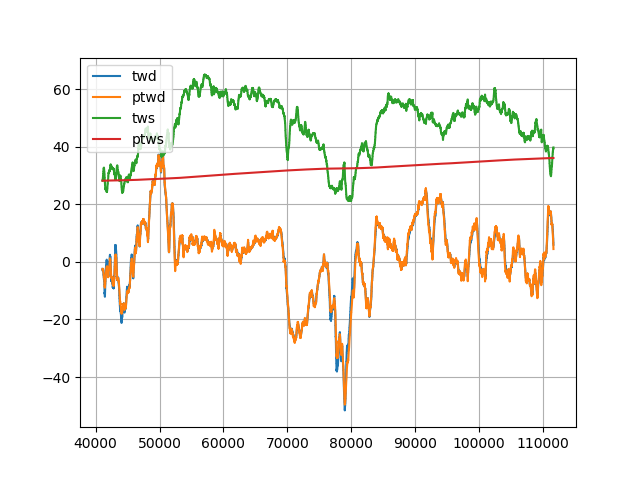

In [119]:
m = [ 0.9981,  1.0024,  1.106 , -0.026 , 16.109 ,  0.0003]
m = [ 1.0011,  1.0014,  1.0986,  0.0249, 14.3761,  0.0003]
m = [ 1.0014,  1.8545,  2.0415, -0.0007,  0.0101,  0.0002]
if True:
    # Check out these magic numbers...  more below
    # [ 0.9981,  1.0024,  1.106 , -0.026 , 16.109 ,  0.0003],
    param = dict(
        epsilon = m[5],
        df = df,
        awa_mult = m[0],
        aws_mult = m[1],
        spd_mult = m[2],
        awa_offset = m[3],
        tws_mult = m[4])
    (twd, tws, res_n, res_e) = estimate_true_wind(**param)
    df['ptwd'] = twd
    df['ptwa'] = twd - (df.rhdg + variation)
    df['ptws'] = tws

wdf = df.loc[tacks_slice]    
wdf = df
print((wdf.rtwa - wdf.ptwa).abs().mean())
print((wdf.rtwd - wdf.ptwd).abs().mean())
print((wdf.rtws - wdf.ptws).abs().mean())

c.quick_plot(wdf.index, (wdf.rtwa, wdf.ptwa), "rtwa predicted_twa".split())
    
wdf = df
c.quick_plot(wdf.index, (wdf.rtwd-180, wdf.ptwd-180, 10*wdf.rtws, 10*wdf.ptws),
                 "twd ptwd tws ptws awa".split())

I was astonished at the quality of this fit.

1. The shape and details are almost everywhere identical, down to the finest details.
1. There areas where the match is not perfect corresponds to areas with very low TWS (2 knots).

From this I conclude that we have the correct algorithm.

Note, the magic numbers above can be automatically estimated from optimization code below.

In [120]:
from scipy.optimize import minimize

# Returns a score base on the fit between our predicted TWS/TWD and the logged quantities.
def fit(m):
    (twd, tws, res_n, res_e) = estimate_true_wind(m[5], df, m[0], m[1], m[2], m[3], m[4])    
    df['ptwd'] = twd
    df['ptwa'] = twd - (df.rhdg + variation)
    df['ptws'] = tws

    wdf = df
    ctwa = 0.2 * (wdf.rtwa - wdf.ptwa).abs().mean()
    ctwd = 1 * (wdf.rtwd - wdf.ptwd).abs().mean()
    ctws = 1 * (wdf.rtws - wdf.ptws).abs().mean()
    return ctwa + ctwd + ctws

# Initial conditions
m0 = np.array([1.0, 1.0, 1.0, 0.0, 30, 0.0001])

# Note this can take up to a minute.
res = minimize(fit, m0, method='nelder-mead',
               options={'xatol': 1e-5, 'disp': True})



In [121]:
print(res)
m1 = res.x

 final_simplex: (array([[ 1.0011,  1.0014,  1.0986,  0.0249, 14.3761,  0.0003],
       [ 1.0021,  1.0014,  1.0974,  0.0244, 14.7973,  0.0003],
       [ 1.0011,  1.0017,  1.099 ,  0.0241, 14.4609,  0.0003],
       [ 1.0011,  1.0018,  1.099 ,  0.0243, 14.2571,  0.0003],
       [ 1.001 ,  1.0025,  1.1001,  0.0244, 14.2711,  0.0003],
       [ 1.0014,  1.0019,  1.0998,  0.0238, 14.7486,  0.0003],
       [ 1.0012,  1.0013,  1.0985,  0.0244, 13.9274,  0.0003]]), array([1.3481, 1.3483, 1.3487, 1.3487, 1.3489, 1.3489, 1.349 ]))
           fun: 1.348131906354615
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1200
           nit: 775
        status: 1
       success: False
             x: array([ 1.0011,  1.0014,  1.0986,  0.0249, 14.3761,  0.0003])


## Summary

We have proposed a new iterative algorithm for estimating TWD/TWS directly, and from this computing TWA.  

The framework does not have a separate estimate and then smooth step (as we did earlier). Smoothness depends on epsilon.  And it near perfectly fits the quantities estimated on the boat!

While this explains the mystery of TW on the boat, **the estimates are almost certainly wrong**!

Below let's drill down to some tacks.

<IPython.core.display.Javascript object>


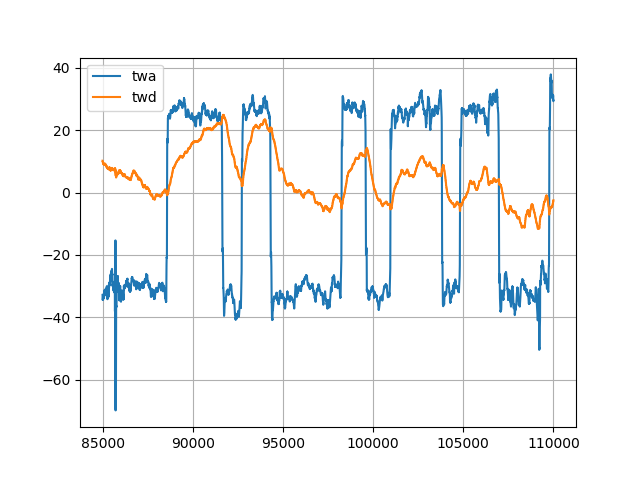

In [44]:
wdf = df.loc[tacks_slice]    

c.quick_plot(wdf.index, (wdf.sawa, wdf.rtwd-180),
                 "twa twd".split())

Notice how the TWD seems to be tightly coupled to the tacks.  Every tack leads to a rapid change in TWD, but 15 degrees.  **This is almost certainly an artifact.**

5.550171059214095


<IPython.core.display.Javascript object>


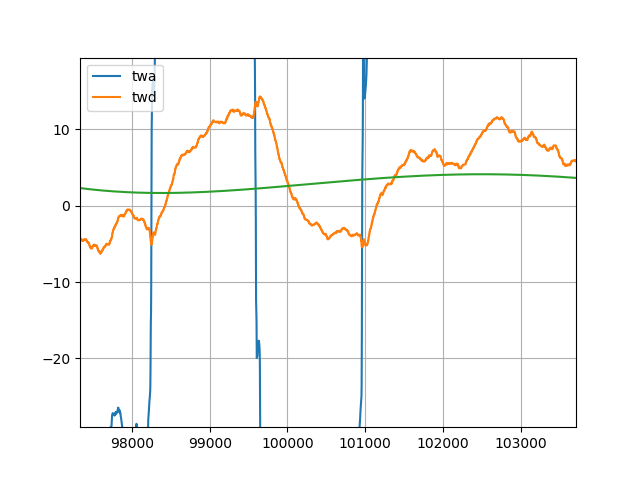

In [52]:
coeff = p.butterworth_filter(cutoff=0.001, order=3)

stwd = p.smooth_angle(coeff, wdf.rtwd, causal=False)
artifact = wdf.rtwd - stwd

print(np.std(artifact))

c.quick_plot(wdf.index, (wdf.sawa, wdf.rtwd-180, stwd-180, ),
                 "twa twd".split())

In [101]:
# coeff = p.butterworth_filter(cutoff=0.001, order=3)


# Returns a score base on the fit between our predicted TWS/TWD and the logged quantities.
def fit(m):
    (twd, tws, res_n, res_e) = estimate_true_wind(m[5], df, m[0], m[1], m[2], m[3], m[4])    
    df['ptwd'] = twd
    df['ptwa'] = twd - (df.rhdg + variation)
    df['ptws'] = tws

    # wdf = df.loc[tacks_slice]    
    wdf = df
    
    stwd = p.smooth_angle(coeff, wdf.rtwd, causal=False)
    artifact = np.std(wdf.ptwd - stwd)
    error = np.std(res_n) + np.std(res_e)
    # print(m)
    # print(artifact, error)

    return artifact

# Initial conditions
m0 = np.array([1.1, 1.1, 1.1, 0, 30, 0.0001])

# Note this can take up to a minute.
res = minimize(fit, m0, method='nelder-mead',
               options={'xatol': 1e-5, 'disp': True, 'maxiter': 500})

res

 final_simplex: (array([[ 1.0159,  0.5806,  0.5437, -0.0119, 63.5346,  0.0001],
       [ 1.016 ,  0.5813,  0.5444, -0.0119, 64.0109,  0.0001],
       [ 1.0159,  0.5793,  0.5426, -0.0119, 63.4328,  0.0001],
       [ 1.0159,  0.5787,  0.542 , -0.012 , 63.1157,  0.0001],
       [ 1.0158,  0.5816,  0.5448, -0.0119, 64.9685,  0.0001],
       [ 1.0159,  0.5846,  0.5475, -0.0118, 64.9957,  0.0001],
       [ 1.0159,  0.5804,  0.5436, -0.0119, 63.5995,  0.0001]]), array([3.6652, 3.6652, 3.6652, 3.6652, 3.6652, 3.6652, 3.6652]))
           fun: 3.665165004656945
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 769
           nit: 500
        status: 2
       success: False
             x: array([ 1.0159,  0.5806,  0.5437, -0.0119, 63.5346,  0.0001])

[ 0.9981  1.0024  1.106  -0.026  16.109   0.0003]


<IPython.core.display.Javascript object>


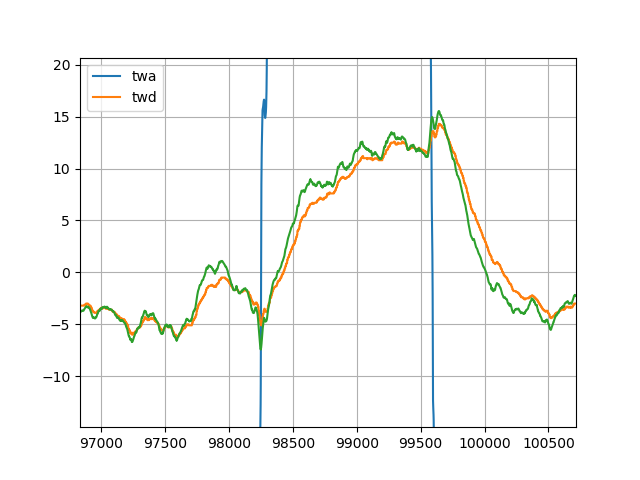

In [109]:
print(m1)
if True:
    m = res.x
    m = m1
    m = [ 0.95,  1.0024,  1.106,  -0.026,  16.109,   0.0003]
    m = m1
    (twd, tws, res_n, res_e) = estimate_true_wind(m[5], df, m[0], m[1], m[2], m[3], m[4]) 
    df['ptwd'] = twd
    df['ptwa'] = twd - (df.rhdg + variation)
    df['ptws'] = tws

wdf = df    
wdf = df.loc[tacks_slice]


c.quick_plot(wdf.index, (wdf.sawa, wdf.rtwd-180, wdf.ptwd-180, ),
                 "twa twd".split())



In [ ]:
print(df.twa.min())

print((df.twa - df.ptwa).abs().mean())
(df.twa - df.ptwa).mean()

In [ ]:
def estimate_true_wind_corrected(epsilon, df, awa_mult=1.0, aws_mult=1.0, spd_mult=1.0):
    return estimate_true_wind_helper(epsilon,
                                     aws = aws_mult * np.asarray(df.caws),
                                     awa = awa_mult * np.asarray(df.cawa),
                                     hdg = np.asarray(df.rhdg),
                                     spd = spd_mult * np.asarray(df.spd),
                                     tws = df.tws.iloc[0],
                                     twd = df.twd.iloc[0],
                                     variation = df.variation.mean())


In [ ]:
sdf = df.loc[example.begin : example.end]

(twd, tws, res_n, res_e) = estimate_true_wind(0.00008, sdf, 1.0, 1.0, 1.0)    

print(np.mean(res_e), np.std(res_e))
print(np.mean(res_n), np.std(res_n))